In [2]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.ticker
import scipy.signal
import scipy.optimize as op
import plasmapy
import matplotlib.cm as cm
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
import numba as nb
%config InlineBackend.figure_format = 'svg'

# Simulation of self-consistent electron hole

## Theory
### Schamel distribution
$$ f_e (v^2>2\phi) = \exp \left[ -\frac{\left(\sqrt{v^2-2\phi}+u\right)^2}{2} \right] $$
$$ f_e (v^2<2\phi) = \exp \left[ -\beta \left(\frac{v^2}{2}-\phi\right) - \frac{u^2}{2} \right] $$
其中$v$为孤波参考系中的速度，静系速度$v_0=v+u$
- 此分布下的自洽孤波，用Newton-Raphson法解出

### 静态$Sech^{4/3}$分布
$$ f_u(w>0) = \frac{1}{\sqrt{2\pi}} e^{-w} $$
$$ f_t(w<0) = 1 -w -\alpha w^2 $$
其中$w=v^2/2-\phi$
- 要求：$v=0$是极小值，并$f(v=0)>0$
$$\frac{d^2 f_t(v=0)}{dv^2} > 0 \Rightarrow \alpha > \frac{1}{2\psi}$$ 
$$f_t(v=0)>0 \Rightarrow \alpha < \frac{1+\psi}{\psi^2}$$
- $\alpha$越大，$\psi$越小

In [199]:
T = 1
k = 0.1
L = 2*np.pi/k

u = 0.0
beta = -3
alpha = 100

vmax = 5 # 速度最大值
nx = 1000
nv = 1000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

dt = 0.02
max_steps  = 10000
data_steps = max_steps
data_num = int(max_steps/data_steps)+1
d = 0.1
linear_time = 2*np.pi/np.sqrt(d)

path = '../data/'
print(data_num)
print('k=',k)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)
print('linear time=',linear_time)

2
k= 0.1
limited time= 6276.9021218724065
real time =  200.0
linear time= 19.869176531592203


In [200]:
@nb.jit
def nonvec_f_fun(v,phi):
    r = 0
    w = (v**2)/2-phi
    if w>0:
        r = np.exp(-((2*w)**0.5+u)**2/2) 
    else:
        r = 1 - w - alpha*w**2
    return r/(2*np.pi)**0.5

# @nb.jit
# def nonvec_f_fun(v,phi):
#     r = 0
#     v_waveframe = v
#     w = v_waveframe**2-2*phi
#     if v_waveframe<=-(2*phi)**0.5:
#         r=np.exp(-(-(w)**0.5+u)**2/2) 
#     elif v_waveframe>(2*phi)**0.5:
#         r=np.exp(-( (w)**0.5+u)**2/2) 
#     else:
#         r = np.exp(-beta*(w/2)-u**2/2) 
#     return r/np.sqrt(2*np.pi)
f_fun = np.vectorize(nonvec_f_fun)

In [201]:
# r1 = 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
# b = np.exp(-u**2)*(1-beta-u**2)/np.sqrt(np.pi)

# psi = (r1*15/16/b)**2
# delta = 4.0/np.sqrt(r1)

# print(delta)
# print(psi)

In [207]:
psi = 0.09
alpha_min = 0.25/psi
alpha_max = (1+psi)/psi**2
print("alpha_min",alpha_min)
print("alpha_max",alpha_max)
xp = (x-L/2)/4.0
phi = psi*np.cosh(xp)**(-4)
# phi = np.ones(nx)*psi
# phi = -1.0*x*(x-L)*psi

alpha_min 2.7777777777777777
alpha_max 134.56790123456793


In [208]:
for count in tqdm(range(20)):
    V,Phi=np.meshgrid(v,phi)
    f_matrix = f_fun(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi[1:nx-1] += dphi
    
    err = ((dphi/phi[1:nx-1])**2).sum()
    if err<= 1e-5:
        print("Sucess! Iteration counts =", count)
        print("err =", err)
        break

 20%|████████████████▌                                                                  | 4/20 [00:01<00:05,  2.87it/s]

Sucess! Iteration counts = 4
err = 1.2560795020214919e-06


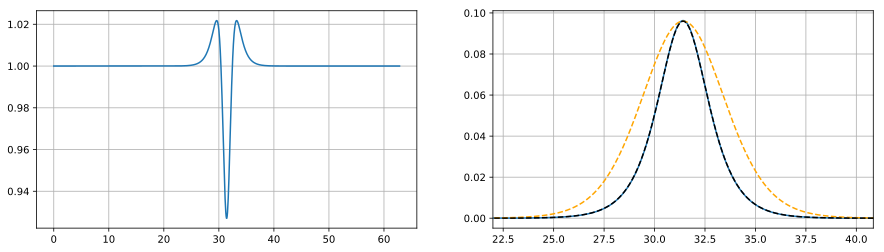

In [210]:
psi = 0.096
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
ax1.plot(x,n_vector)
ax1.grid()
# ax2 = plt.subplot(132)
# ax2.plot(x,E)
# ax2.grid()
ax3 = plt.subplot(122)
ax3.plot(x,phi)
ax3.plot(x,psi*np.cosh((x-L/2)/4)**(-4),color='orange',linestyle='--')
ax3.plot(x,psi*np.cosh((x-L/2)/4*3)**(-4/3),color='black',linestyle='--')
ax3.grid()
ax3.set_xlim(0.35*L,0.65*L)
plt.show()

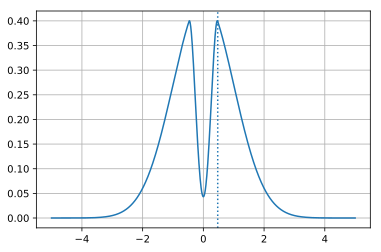

In [168]:
V,Phi=np.meshgrid(v,phi)
f_matrix = f_fun(V,Phi)
fv = f_matrix.sum(axis=0)*dx/L
plt.plot(v,f_matrix[500,])
plt.axvline(np.sqrt(2*psi),linestyle=':')
# plt.xlim(0.2,0.6)
# plt.ylim(0.3,0.41)
plt.grid()

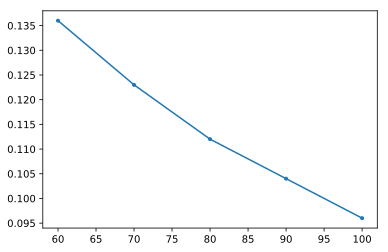

In [192]:
# a_list = [90,80,70,60,50,40,30,20,10,5,2]
# psi_list = [0.104,0.112,0.123,0.136,0.155,0.181,0.22,0.29,0.471,0.78,1.54]
a_list = [100,90,80,70,60]
psi_list = [0.096,0.104,0.112,0.123,0.136]
plt.plot(a_list,psi_list,'.-')